In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [34]:
df=pd.read_csv("AER_credit_card_data.csv")

In [31]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df["card"]=df.card.apply(lambda x: 1 if x=="yes" else 0)

In [5]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [6]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

y=df.card.values
X=df[['reports', 'age', 'income', 'share', 'expenditure', 'owner','selfemp', 'dependents', 'months', 'majorcards', 'active']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio,random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,random_state=1, test_size=validation_ratio/(train_ratio+test_ratio))

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(791, 11)
(264, 11)
(264, 11)


In [8]:
X_train.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1105,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
431,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
407,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
1217,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
1133,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4


In [9]:
feature_impt_numerical=["reports","dependents","active","share"]

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
roc_auc_score(y_train, X_train.reports.values)

0.28333701393106236

## Q1 Solution

In [12]:
for col in feature_impt_numerical:
    print("column:",col,roc_auc_score(y_train, X_train[col].values))
    

column: reports 0.28333701393106236
column: dependents 0.46722427722262094
column: active 0.6043173411362006
column: share 0.989183643423692


In [13]:
#one hot encoding
from sklearn.feature_extraction import DictVectorizer

In [14]:
train_dict = X_train.to_dict(orient='records')

In [15]:
train_dict[0]

{'reports': 3,
 'age': 40.5,
 'income': 4.0128,
 'share': 0.0002990431,
 'expenditure': 0.0,
 'owner': 'no',
 'selfemp': 'no',
 'dependents': 1,
 'months': 12,
 'majorcards': 1,
 'active': 17}

In [16]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [17]:
X_train = dv.transform(train_dict)

In [18]:
X_train[0]

array([1.700000e+01, 4.050000e+01, 1.000000e+00, 0.000000e+00,
       4.012800e+00, 1.000000e+00, 1.200000e+01, 1.000000e+00,
       0.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
       2.990431e-04])

In [19]:
X_train.shape

(791, 13)

In [20]:
dv.get_feature_names()

['active',
 'age',
 'dependents',
 'expenditure',
 'income',
 'majorcards',
 'months',
 'owner=no',
 'owner=yes',
 'reports',
 'selfemp=no',
 'selfemp=yes',
 'share']

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
val_dict = X_valid.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]


## Q2 solution

In [23]:
roc_auc_score(y_valid, y_pred )

0.995171242063847

In [24]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0.0 , 1.0, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    df_scores["f1"]=2*df_scores.precision*df_scores.recall/(df_scores.precision+df_scores.recall)
    
    #F1 = 2 * P * R / (P + R)
    
    
    return df_scores

In [25]:
df_rand=tpr_fpr_dataframe(y_valid, y_pred )

## Q3 and Q4 Solution

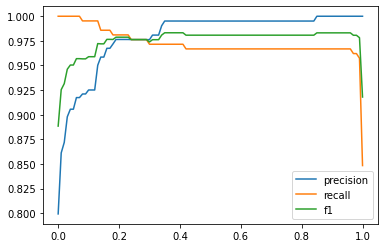

In [26]:
plt.plot(df_rand.threshold, df_rand['precision'], label='precision')
plt.plot(df_rand.threshold, df_rand['recall'], label='recall')
plt.plot(df_rand.threshold, df_rand['f1'], label='f1')
plt.legend()

## Cross-Validation

In [35]:
df["card"]=df.card.apply(lambda x: 1 if x=="yes" else 0)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values



In [23]:
def train(X_train, y_train, C,max_iter):
    dicts = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model=LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [36]:
df_train.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [38]:
#LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

dv, model = train(df_train, y_train,1.0,1000)

In [39]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
y_pred = predict(df_val, dv, model)

## Q5 solution

In [53]:
n_splits = 5

for C in tqdm([0.1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values
                  
        dv, model = train(df_train, y_train, C=C,max_iter=1000)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        #print(auc)
        scores.append(auc)

        print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.1 0.998 +- 0.000
C=0.1 0.998 +- 0.000
C=0.1 0.999 +- 0.001
C=0.1 0.999 +- 0.001
C=0.1 0.999 +- 0.001



## Q6 solution

In [49]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values
                  
        dv, model = train(df_train, y_train, C=C,max_iter=1000)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.993 +- 0.005
C=0.1 0.999 +- 0.001
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000

